In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torchvision
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch.nn import Conv2d

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [5]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)


C:\Users\enriq\anaconda3\envs\mlenv\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
#train_data = torch.FloatTensor(train_data).cuda()

In [7]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False, pin_memory=True)


In [8]:
# Grab the first MNIST record
for i, (X_train, y_train) in enumerate(train_data):
    break
    
# Create a rank-4 tensor to be passed into the model
# (train_loader will have done this already)
x = X_train.view(1,1,28,28)
print(x.shape)
x.device

torch.Size([1, 1, 28, 28])


device(type='cpu')

In [9]:
model = torchvision.models.GoogLeNet(num_classes=10)
model.conv1 = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) 
model = model.cuda()

C:\Users\enriq\anaconda3\envs\mlenv\lib\site-packages\torchvision\models\googlenet.py:77: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of GoogleNet will be changed in future releases of '


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        X_train, y_train = X_train.cuda(), y_train.cuda()
        b+=1
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        y_pred = y_pred[0]
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.cuda(), y_test.cuda()
            # Apply the model
            y_val = model(X_test)
            y_val = y_val[0]
            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed       

C:\Users\enriq\anaconda3\envs\mlenv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch:  0  batch: 1000 [ 10000/60000]  loss: 0.69539171  accuracy:  57.340%
epoch:  0  batch: 2000 [ 20000/60000]  loss: 0.13923028  accuracy:  68.940%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 1.74796832  accuracy:  74.487%
epoch:  0  batch: 4000 [ 40000/60000]  loss: 0.01128235  accuracy:  77.855%
epoch:  0  batch: 5000 [ 50000/60000]  loss: 0.52357262  accuracy:  80.408%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.07832879  accuracy:  82.347%
epoch:  1  batch: 1000 [ 10000/60000]  loss: 6.25197363  accuracy:  92.500%
epoch:  1  batch: 2000 [ 20000/60000]  loss: 0.85622633  accuracy:  93.210%
epoch:  1  batch: 3000 [ 30000/60000]  loss: 0.46616817  accuracy:  93.360%
epoch:  1  batch: 4000 [ 40000/60000]  loss: 0.01460429  accuracy:  93.752%
epoch:  1  batch: 5000 [ 50000/60000]  loss: 0.09310334  accuracy:  94.086%
epoch:  1  batch: 6000 [ 60000/60000]  loss: 1.67066312  accuracy:  94.260%
epoch:  2  batch: 1000 [ 10000/60000]  loss: 0.02169044  accuracy:  96.430%
epoch:  2  b

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not GoogLeNetOutputs


In [12]:
test_losses_item = []
for i in test_losses:
    print(i)
    test_losses_item.append(i.item())
test_losses_item

tensor(0.1385, device='cuda:0')
tensor(0.0135, device='cuda:0')
tensor(0.0014, device='cuda:0')
tensor(0.0044, device='cuda:0')
tensor(0.0038, device='cuda:0')


[0.13847817480564117,
 0.013533773832023144,
 0.0014278881717473269,
 0.004420178942382336,
 0.0038184747099876404]

[0.07832878828048706, 1.6706631183624268, 0.17384180426597595, 0.012197964824736118, 0.05006216838955879]
[tensor(0.1385, device='cuda:0'), tensor(0.0135, device='cuda:0'), tensor(0.0014, device='cuda:0'), tensor(0.0044, device='cuda:0'), tensor(0.0038, device='cuda:0')]


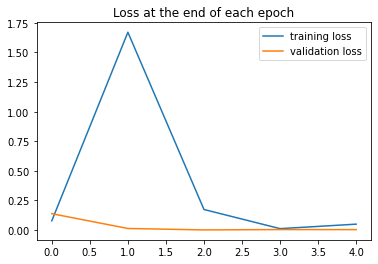

In [13]:
print(train_losses)
print(test_losses)
plt.plot(train_losses, label='training loss')
plt.plot(test_losses_item, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

In [14]:
test_correct_item = []
for i in test_correct:
    print(i.item())
    test_correct_item.append(i.item())
test_correct_item

9044
9562
9767
9792
9862


[9044, 9562, 9767, 9792, 9862]

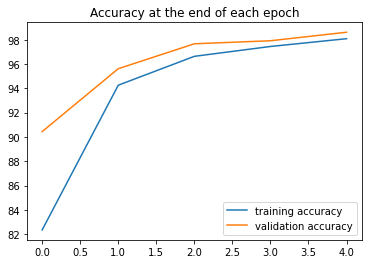

In [15]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct_item], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [16]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [17]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test, y_test = X_test.cuda(), y_test.cuda()
        y_val = model(X_test)  # we don't flatten the data this time
        y_val = y_val[0]
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9891/10000 =  98.910%


In [18]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

109

In [28]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

True
Index: tensor([247, 445, 449, 582, 659, 674, 716, 717, 726, 829, 900],
       device='cuda:0')
Label: tensor([4, 6, 3, 8, 2, 5, 1, 0, 7, 4, 1], device='cuda:0')
Guess: tensor([1, 0, 5, 2, 1, 3, 7, 8, 5, 9, 2], device='cuda:0')


C:\Users\enriq\AppData\Local\Temp/ipykernel_7828/2165462237.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("Label:", y_test.index_select(0,torch.tensor(nextrow)))
C:\Users\enriq\AppData\Local\Temp/ipykernel_7828/2165462237.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("Guess:", predicted.index_select(0,torch.tensor(nextrow)))
C:\Users\enriq\AppData\Local\Temp/ipykernel_7828/2165462237.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = X_test.index_select(0,torch.tensor(nextrow))


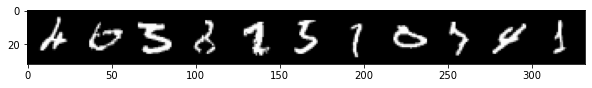

In [29]:
nextrow = next(row)
nextrow = torch.from_numpy(nextrow).to(device)
print(nextrow.is_cuda)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)))
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.cpu().numpy(), (1, 2, 0)));

tensor(5000)


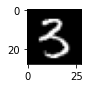

In [30]:
x = 5000
x = torch.tensor(x)
print(x)
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape((28,28)), cmap="gray");

In [31]:
model.eval()
with torch.no_grad():
    new_pred = model(X_test[x][0].view(1,1,28,28)).argmax()
print("Predicted value:",new_pred.item())

Predicted value: 3
